<a href="https://colab.research.google.com/github/McPatrik/Diamonds/blob/main/diamonds_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

для просмотра графиков кликай сюда ⏫

# **Задача**
Произвести предсказания цен на бриллианты, используя алгоритмы машинного обучения, а именно линейную регрессию, дерево решений, catboost и случайный лес, определить какие из признаков оказывают максимальное влияние на предсказанную стоимость. На основании метрик оценки качества моделей выбрать наиболее подходящий алгоритм, в дальнейшем для которого подобрать параметры, использование которых покажет наибольшую эффективность модели.

# Данные для исследования

Файл был взят с платформы Kaggle, https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

Это набор данных, содержащий примерно 54 000 бриллиантов круглой огранки и их стоимость в $, а также такие признаки как
- карат,
- глубина в %,
- площадка(самая большая грань бриллианта) в %,  
- ромбовидные измерения в мм, где x - длина, y -ширина, z - глубина.

Установка и импорт необходимых для работы библиотек.

In [ ]:
! pip install catboost
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from catboost import CatBoostRegressor, Pool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Обработка данных

Прочтём фаил и познакомимся с данными поближе

Точное количество наблюдений 53923.

Датасет содержит 11 признаков, из них 7 числовых (карат, глубина, площадка и стоимость, x, y, z) и 4 категориальных (огранка, цвет и чистота)

Пропусков в данных нет.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/archive(1)/Diamonds Prices2022.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [ ]:
df.describe()

carat         depth         table         price             x  \
count  53923.000000  53923.000000  53923.000000  53923.000000  53923.000000   
mean       0.797693     61.749432     57.456902   3930.927879      5.731628   
std        0.473783      1.432336      2.234123   3987.179153      1.119392   
min        0.200000     43.000000     43.000000    326.000000      3.730000   
25%        0.400000     61.000000     56.000000    949.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5322.500000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53923.000000  53923.000000  
mean       5.734888      3.540042  
std        1.140094      0.702511  
min        3.680000      1.070000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.900000     31.800000

Обратили внимания, что минимальные значения таких параметров как x, y, z могут равняться 0, что не является логичным и допустимым, потому необходимо удалить их, к тому же таких наблюдений немного - 20.

In [ ]:
df[((df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0))].count()

Unnamed: 0    20
carat         20
cut           20
color         20
clarity       20
depth         20
table         20
price         20
x             20
y             20
z             20
dtype: int64

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)
df = df[~((df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0))]

# Описание данных

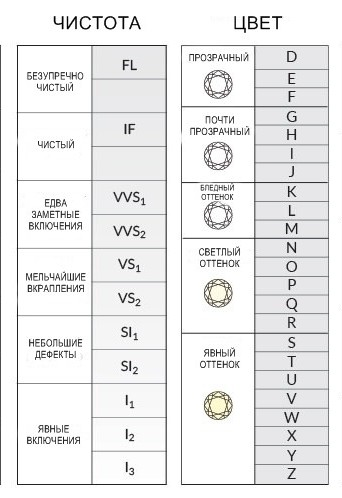

Категориальные признаки бриллиантов- это чистота, цвет, и качество огранки. Выше представлено изображение, поясняющее условные обозначения. Среди нашего набора данных наиболее часто встречающие значения, чистоты - SI1 (небольшие дефекты), цвет - G (почти прозрачный) и бриллианты идеальной огранки.

In [ ]:
df[['cut', 'color', 'clarity']].describe()

cut  color clarity
count   53923  53923   53923
unique      5      7       8
top     Ideal      G     SI1
freq    21548  11284   13065

Построим графики распределения числовых признаков.(Ниже представлены графики распределения числовых признаков)


In [ ]:
trace1 = go.Histogram(x=df['depth'], name='Diamond Depth Distribution', marker=dict(color='#4ebded'))
trace2 = go.Histogram(x=df['carat'], name='Diamond cutting distribution', marker=dict(color='#4ebded'))
trace3 = go.Histogram(x=df['table'], name='Diamond distribution table', marker=dict(color='#4ebded'))
trace4 = go.Histogram(x=df['price'], name='Distribution of diamond prices', marker=dict(color='#4ebded'))
trace5 = go.Histogram(x=df['x'], name='Diamond Length Distribution', marker=dict(color='#4ebded'))
trace6 = go.Histogram(x=df['y'], name='Diamond Width Distribution', marker=dict(color='#4ebded'))
trace7 = go.Histogram(x=df['z'], name='Diamond Depth Distribution', marker=dict(color='#4ebded'))

fig = make_subplots(rows=3, cols=3, subplot_titles=('Diamond Depth Distribution', 'Diamond cutting distribution', 'Diamond distribution table', 'Distribution of diamond prices', 'Diamond Length Distribution', 'Diamond Width Distribution', '', 'Diamond Depth Distribution'))
fig.append_trace(trace1, col = 1, row = 1)
fig.append_trace(trace2, col = 2, row = 1)
fig.append_trace(trace3, col = 3, row = 1)
fig.append_trace(trace4, col = 1, row = 2)
fig.append_trace(trace5, col = 2, row = 2)
fig.append_trace(trace6, col = 3, row = 2)
fig.append_trace(trace7, col = 2, row = 3)
fig.update_layout(height=1150, width=1740)
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50))
fig.update_xaxes(title='Depth', col=1, row=1)
fig.update_yaxes(title='Count', col=1, row=1)
fig.update_xaxes(title='Carat', col=2, row=1)
fig.update_yaxes(title='Count', col=2, row=1)
fig.update_xaxes(title='Table', col=3, row=1)
fig.update_yaxes(title='Count', col=3, row=1)
fig.update_xaxes(title='Price', col=1, row=2)
fig.update_yaxes(title='Count', col=1, row=2)
fig.update_xaxes(title='Length (x)', col=2, row=2)
fig.update_yaxes(title='Count', col=2, row=2)
fig.update_xaxes(title='Width (y)', col=3, row=2)
fig.update_yaxes(title='Count', col=3, row=2)
fig.update_xaxes(title='Depth (z)', col=2, row=3)
fig.update_yaxes(title='Count', col=2, row=3)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
trace1 = go.Pie(values=df.groupby('color', as_index=False)['cut'].count()['cut'], labels=df.groupby('color', as_index=False)['cut'].count()['color'], textinfo='label+percent')

trace2 = go.Pie(values=df.groupby('cut', as_index=False)['color'].count()['color'], labels=df.groupby('cut', as_index=False)['color'].count()['cut'], textinfo='label+percent')

trace3 = go.Pie(values=df.groupby('clarity', as_index=False)['color'].count()['color'], labels=df.groupby('clarity', as_index=False)['color'].count()['clarity'], textinfo='label+percent')

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]], subplot_titles=('The prevalence of diamond color', 'The prevalence of the diamond cut', 'The prevalence of diamond clarity'))
fig.append_trace(trace1, col = 1, row = 1)
fig.append_trace(trace2, col = 2, row = 1)
fig.append_trace(trace3, col = 3, row = 1)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=50))
fig.update_layout(showlegend=False)
fig.show()


Графики по % распределению категориальных признаков в данных. Что касается цвета бриллианта, лидирует G (почти прозрачный), затем E (прозрачный) и F(прозрачный). По качеству огранки идеальный занимает большую часть наблюдений, затем идёт премиум и очень хорошего качества. По чистоте лидирует SI1(большие дефекты) и VS2 (мельчайшие вкрапления),бриллиантов с явными включениями 1.37% L1, чистых 3.32% LF

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='PuBu')

<ipython-input-14-bea1644dac87>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



По матрице корреляции мы видим, вероятную взаимосвязь между каратом и ценой, а также величинами x,y,z, что является вполне логичным.

Построим "ящики с усами" по числовым признакам.

In [ ]:
trace1 = go.Box(
y=df['price'],
name='Cost in $'
)

trace2 = go.Box(
y=df['carat'],
name='Carat'
)

trace3 = go.Box(
y=df['table'],
name='Table %'
)

trace4 = go.Box(
y=df['depth'],
name='Depth %'
)
trace5 = go.Box(
y=df['x'],
name='Length (mm)'
)
trace6 = go.Box(
y=df['y'],
name='Width (mm)'
)
trace7 = go.Box(
y=df['z'],
name='Depth (mm)'
)
fig = make_subplots(rows=1, cols=7, subplot_titles=('Price', 'Carat', 'Table', 'Depth', 'Length (x)', 'Width (y)', 'Depth (z)'))
fig.append_trace(trace1, row=1, col=1)
fig.append_trace(trace2, row=1, col=2)
fig.append_trace(trace3, row=1, col=3)
fig.append_trace(trace4, row=1, col=4)
fig.append_trace(trace5, row=1, col=5)
fig.append_trace(trace6, row=1, col=6)
fig.append_trace(trace7, row=1, col=7)
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50))
fig.update_layout(height=500, width=1700)
fig.show()

На графиках видно, что ряд признаков имеет значительное количество выбросов, исходя из этого, высока вероятность исказить результаты предсказаний при использовании линейной регрессии. Такие модели как  решающие деревья и случайный лес менее чувствительны к выбросам в данных.

# Предсказания

Для того чтобы использовать алгоритмы для предсказания стоимости необходимо преобразовать категориальные признаки объекта в числовые. Для этого будет созданы столбцы с категориальными признаками + его значение, если мы наблюдаем это значение у наблюдения 1 иначе 0.

In [ ]:
for i in ['cut', 'color', 'clarity']:
  for j in df[i].unique():
    df[i+'_' + j] = (df[i] == j).astype(int)

In [ ]:
a = [i for i in df.columns if '_' in i or i in ['y', 'z', 'x', 'depth', 'carat', 'table']]

Для прогнозирования стоимости будет использовано 4 алгоритма со стандартными параметрами:
- Линейная регрессия
- Решающие деревья
- Случайный лес
- Catboost



В последствии, будет выбран один для более точной настройки параметров и повышения качества модели.


Предварительно сделаем разбивку наших данных на тестовую и обучающую, в размерах 20% и 80%, где 20% составляет тестовая часть и 80% обучающая.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[a], df['price'] , test_size=0.2, random_state=0)

Запуск на обучение 4-х алгоритмов.

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

In [ ]:
cbr = CatBoostRegressor()
cbr.fit(X_train, y_train)
y_pred_cbr = cbr.predict(X_test)

Learning rate set to 0.074214
0:	learn: 3732.5347370	total: 71.8ms	remaining: 1m 11s
1:	learn: 3498.8562439	total: 81ms	remaining: 40.4s
2:	learn: 3286.2353837	total: 88.8ms	remaining: 29.5s
3:	learn: 3087.4110921	total: 96.1ms	remaining: 23.9s
4:	learn: 2904.3748673	total: 104ms	remaining: 20.7s
5:	learn: 2732.3605529	total: 111ms	remaining: 18.4s
6:	learn: 2580.9849464	total: 119ms	remaining: 16.8s
7:	learn: 2438.2354645	total: 128ms	remaining: 15.8s
8:	learn: 2306.4390965	total: 135ms	remaining: 14.8s
9:	learn: 2189.3538771	total: 143ms	remaining: 14.1s
10:	learn: 2077.6838093	total: 150ms	remaining: 13.5s
11:	learn: 1976.1648492	total: 157ms	remaining: 12.9s
12:	learn: 1883.1996028	total: 164ms	remaining: 12.5s
13:	learn: 1800.3164494	total: 178ms	remaining: 12.5s
14:	learn: 1723.4627332	total: 189ms	remaining: 12.4s
15:	learn: 1651.1315612	total: 201ms	remaining: 12.4s
16:	learn: 1588.7661865	total: 213ms	remaining: 12.3s
17:	learn: 1530.3327322	total: 222ms	remaining: 12.1s
18:	l

# Оценка качества моделей

После обучения и предсказывания данных, есть необходимость каким-либо образом оценить результат. Для этого было выбрано несколько метрик: средняя абсолютная ошибка (MAE), средняя квадратичная ошибка  (MSE), средняя абсолютная ошибка в процентах  (MAPE) и коэффициент детерминации  (R2)

In [ ]:
df_metrics = {'Metrics': ['Mean_absolute_error', 'Mean_squared_error', 'Mean_absolute_percentage_error', 'R2_score']}
def metrics(actual, predicted, name):
  mae = round(mean_absolute_error(actual, predicted),3)
  mse = round(mean_squared_error(actual, predicted),3)
  mape = round(mean_absolute_percentage_error(actual, predicted),3)
  r2 = round(r2_score(actual, predicted),3)
  df_metrics[name] = [mae, mse, mape, r2]

Запустим функции с передачей наших актуальных и предсказанных значений, а также названием алгоритма. Отобразим в виде таблицы.

In [ ]:
metrics(y_test, y_pred_rfr,'RandomForestRegressor')
metrics(y_test, y_pred_lr,'LinearRegression')
metrics(y_test, y_pred_cbr,'CatBoostRegressor')
metrics(y_test, y_pred_dtr,'DecisionTreeRegressor')

In [ ]:
df_metrics = pd.DataFrame(df_metrics)

In [ ]:
df_metrics

Metrics  RandomForestRegressor  LinearRegression  \
0             Mean_absolute_error                263.553           738.672   
1              Mean_squared_error             284207.716       1291913.239   
2  Mean_absolute_percentage_error                  0.066             0.394   
3                        R2_score                  0.982             0.918   

   CatBoostRegressor  DecisionTreeRegressor  CatBoostRegressor_2  
0            270.908                352.767              266.719  
1         260864.270             522406.112           261099.422  
2              0.077                  0.085                0.074  
3              0.984                  0.967                0.984

Исходя из таблицы видим, что наилучшим образом себя показали 2 алгоритма, случайный лес и catboost, наименее эффективна оказалась линейная регрессия.Для обучения одной модели случайного леса необходимо большое количество времени, если учесть использование алгоритма для подбора наилучших параметров, который будет обучать несколько моделей, это время будет увеличено многократно. Catboost же обучается гораздо быстрее, потому было принято решение, увеличивать эффективность именно этой модели.

🔥

In [ ]:
pd.pivot_table(df_metrics, columns='Metrics').style.background_gradient(cmap='PuBu')

Для подбора наилучших параметров используется GridSearchCV, с передачей разных значений: количества итераций, темпа обучения, глубины и коэффициента при члене регуляризации L2 функции потерь.

In [ ]:
param_cb = {'iterations': [100, 150, 200],
            'learning_rate': [0.01, 0.1, 0.15],
            'depth': [5,12,14],
            'l2_leaf_reg': [0.05, 0.1, 0.2]}

In [ ]:
model = CatBoostRegressor()

In [ ]:
%%time
grid_cb_2 = GridSearchCV(model, param_cb)
grid_cb_2.fit(X_train, y_train, verbose=True)

Streaming output truncated to the last 5000 lines.
2:	learn: 3009.4910073	total: 775ms	remaining: 50.9s
3:	learn: 2734.0484629	total: 1.14s	remaining: 55.7s
4:	learn: 2489.8295412	total: 1.52s	remaining: 59.4s
5:	learn: 2280.6346136	total: 1.89s	remaining: 1m 1s
6:	learn: 2088.7524206	total: 2.27s	remaining: 1m 2s
7:	learn: 1923.2239184	total: 2.65s	remaining: 1m 3s
8:	learn: 1767.5912056	total: 3.02s	remaining: 1m 4s
9:	learn: 1626.7793505	total: 3.4s	remaining: 1m 4s
10:	learn: 1504.0607917	total: 3.79s	remaining: 1m 5s
11:	learn: 1385.5283390	total: 4.17s	remaining: 1m 5s
12:	learn: 1283.6702793	total: 4.55s	remaining: 1m 5s
13:	learn: 1195.0843610	total: 4.62s	remaining: 1m 1s
14:	learn: 1112.2358166	total: 5.08s	remaining: 1m 2s
15:	learn: 1039.9093303	total: 5.74s	remaining: 1m 6s
16:	learn: 976.5190665	total: 6.39s	remaining: 1m 8s
17:	learn: 925.2737307	total: 7.06s	remaining: 1m 11s
18:	learn: 876.6884425	total: 7.71s	remaining: 1m 13s
19:	learn: 832.5147912	total: 8.38s	remai

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f7afc428af0>,
             param_grid={'depth': [12, 14], 'iterations': [150, 200],
                         'l2_leaf_reg': [0.05, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.15]})

Выведем лучшие параметры для модели. Обучим модель и посмотрим на результаты метрик.

In [ ]:
grid_cb_2.best_params_

{'depth': 12, 'iterations': 200, 'l2_leaf_reg': 0.1, 'learning_rate': 0.1}

In [ ]:
model_2 = CatBoostRegressor(depth= 12, iterations = 200, l2_leaf_reg = 0.1, learning_rate = 0.1)
model_2.fit(X_train, y_train)
y_pred_cbr_2 = model_2.predict(X_test)

0:	learn: 3630.1932219	total: 96.3ms	remaining: 19.2s
1:	learn: 3306.1892193	total: 360ms	remaining: 35.7s
2:	learn: 3009.1188130	total: 518ms	remaining: 34s
3:	learn: 2750.4534519	total: 716ms	remaining: 35.1s
4:	learn: 2510.2397894	total: 963ms	remaining: 37.6s
5:	learn: 2309.3280369	total: 1.03s	remaining: 33.4s
6:	learn: 2115.7263023	total: 1.23s	remaining: 33.9s
7:	learn: 1939.3871486	total: 1.4s	remaining: 33.7s
8:	learn: 1788.9450386	total: 1.64s	remaining: 34.8s
9:	learn: 1656.7807832	total: 1.88s	remaining: 35.8s
10:	learn: 1527.5020286	total: 2s	remaining: 34.3s
11:	learn: 1420.4685401	total: 2.16s	remaining: 33.8s
12:	learn: 1324.8387361	total: 2.32s	remaining: 33.4s
13:	learn: 1233.7811929	total: 2.44s	remaining: 32.5s
14:	learn: 1155.0978857	total: 2.58s	remaining: 31.8s
15:	learn: 1084.0968884	total: 2.72s	remaining: 31.3s
16:	learn: 1018.9846422	total: 2.85s	remaining: 30.7s
17:	learn: 963.9447435	total: 2.99s	remaining: 30.2s
18:	learn: 917.1803470	total: 3.15s	remainin

In [ ]:
metrics(y_test, y_pred_cbr_2, 'CatBoostRegressor_2')

Использование параметров подобранных с помощью GridSearch, дало небольшое преимущество по некоторым метрикам, а именно уменьшение MAE, MAPE.

In [ ]:
pd.pivot_table(df_metrics, columns='Metrics').style.background_gradient(cmap='PuBu')

# Важность признаков

Для того, чтобы узнать вклад каждого из признаков в модель, можно использовать feature importance из библиотеки Catboost, отобразив результат на графике, предварительно отсортировав.
Основное влияние на качество предсказаний оказывают: карат, ширина бриллианта,  и его длина.

А также *чистота I2* - означает наличие у бриллианта явных включений, что  оказывает негативное влияние на его стоимость.

In [ ]:
df_fi = pd.DataFrame({'Features': X_test.columns, 'Feature_importances': model_2._feature_importances})
df_fi.sort_values(by='Feature_importances', ascending=False, inplace=True)
df_fi

In [ ]:
fig = px.bar(df_fi, x="Features", y="Feature_importances", barmode="group")
fig.show()

# Визуальное представление актуальных и предсказанных значений

Ниже представлены графики для наглядной оценки полученных результатов, по предсказанию стоимости. Где, красной линией изображена фактическая стоимость бриллианта, а синими точками - результат предсказания модели, соответственно, чем больше расстояние точки от линии, тем больше разрыв между актуальной стоимостью и предсказанной.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred_lr, y=y_test, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='Actual'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Linear Regression",
                  xaxis_title="Predicted",
                  yaxis_title="Actual",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred_dtr, y=y_test, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='Actual'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Decision Tree Regressor",
                  xaxis_title="Predicted",
                  yaxis_title="Actual",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred_rfr, y=y_test, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='Actual'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Random Forest Regressor",
                  xaxis_title="Predicted",
                  yaxis_title="Actual",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred_cbr, y=y_test, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='Actual'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="CatBoost Regressor",
                  xaxis_title="Predicted",
                  yaxis_title="Actual",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_pred_cbr_2, y=y_test, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, name='Actual'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="CatBoost Regressor_2",
                  xaxis_title="Predicted",
                  yaxis_title="Actual",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

Исходя из визуального отображения предсказываний разных алгоритмов. Линейная регрессия, как и говорилось ранее явно проигрывает по предсказыванию другим алгоритмам, уходя в предсказание отрицательной стоимости. Гораздо лучше себя показывают решающие деревья, и конечно 2 алгоритма показавшие себя лучше остальных это случайный лес и catboost.

# Вывод

В процессе работы с набором данных, было использовано 4 алгоритма машинного обучения (линейная регрессия, решающие деревья,случайный лес, catboost), для предсказания стоимости бриллиантов.

Выполнена оценка качества работы алгоритмов на основании ряда метрик.

Алгоритм показавший наилучшие результаты - Catboost Regressor. Помимо достаточно высокой точности предсказания, данный алгоритм показывает и высокую скорость обучения имеет большое количество индивидуальных настроек, что является немаловажным фактором. Для построения финальной модели, был произведен подбор параметров.

Получены следующие результаты:

 - Средняя абсолютная ошибка предсказания составила 266 долларов, учитывая разброс стоимости бриллиантов (std=3987$)

 - Коэффициент детерминации составляет 0.98 (из максимально возможного значения 1), что является отличным результатом

- Выделены наиболее важные признаки влияющие на предсказания (карат, ширина бриллианта, длина, чистота(I2)).

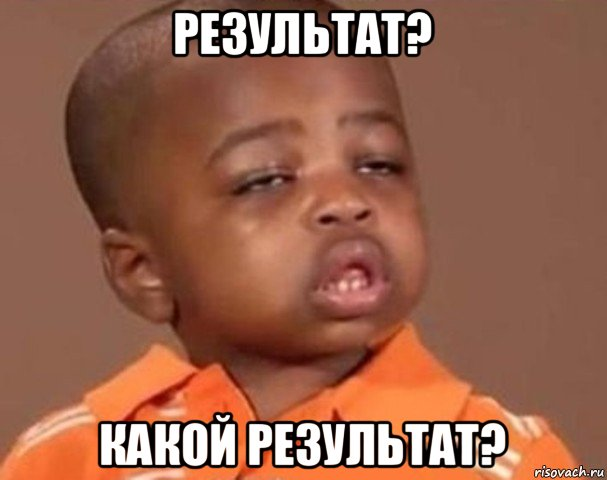